In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from scipy.stats import skew
import xgboost as xgb
import pickle
df = pd.read_csv("diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [45]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [46]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [47]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [48]:
df.duplicated().sum()

np.int64(0)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [50]:
print(df['Outcome'].value_counts())


Outcome
0    500
1    268
Name: count, dtype: int64


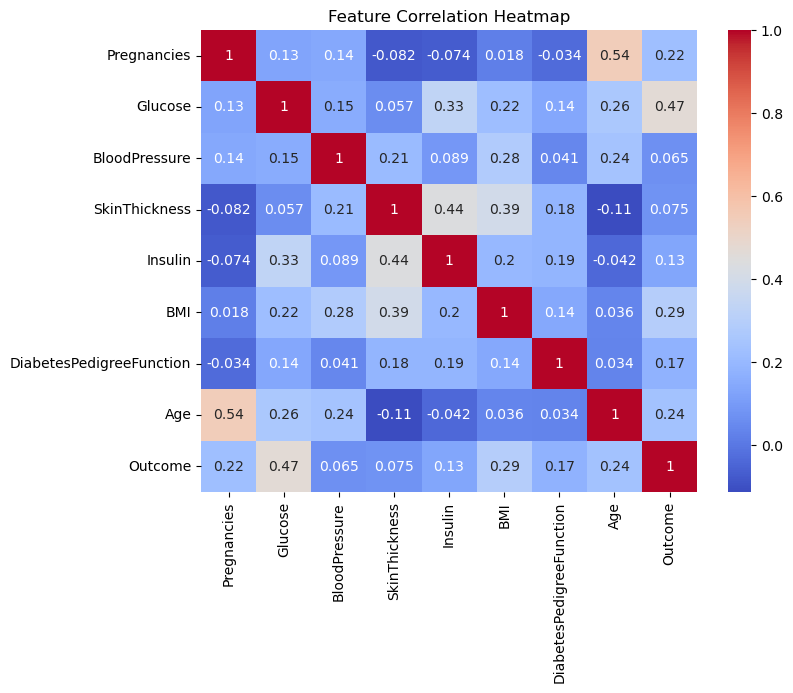

In [51]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

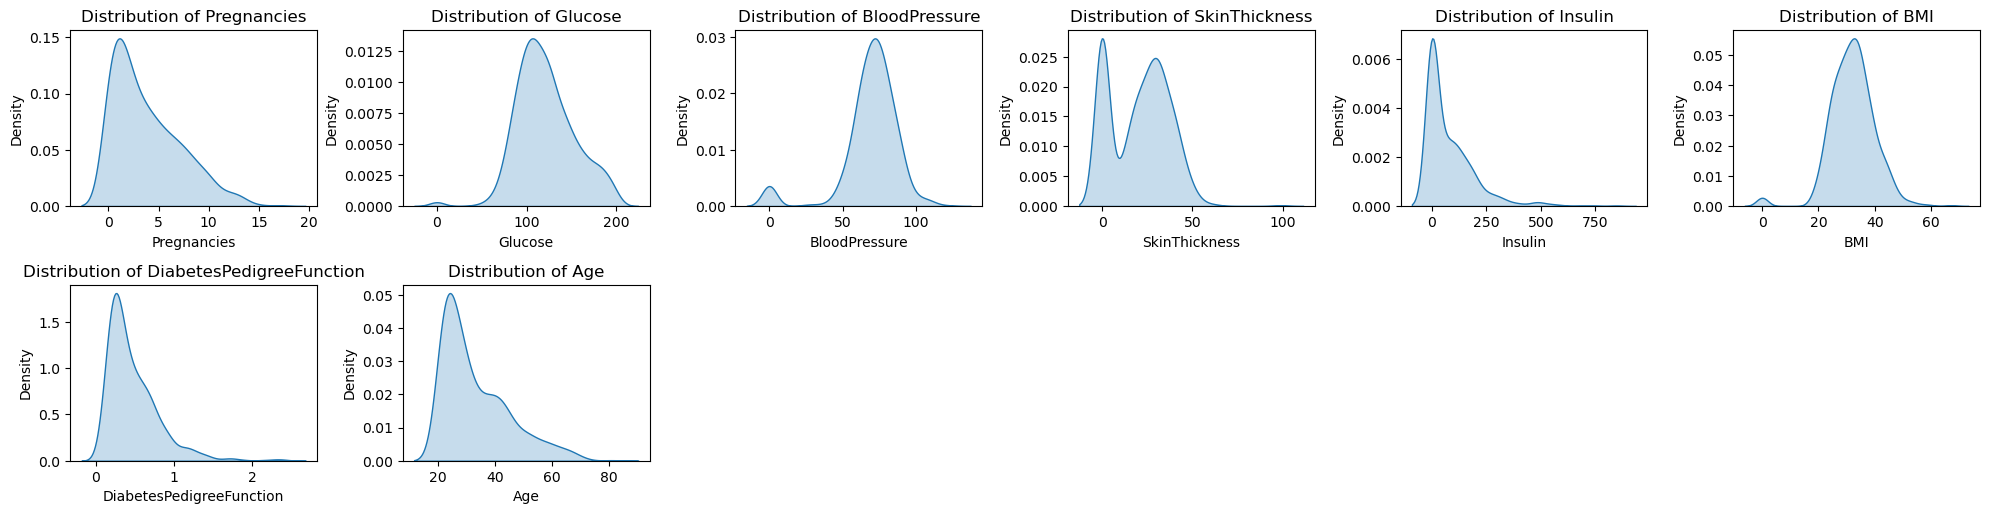

In [52]:
plt.figure(figsize=(20,15))
plot=1
for col in df.columns[:-1]:
    plt.subplot(6,6,plot)
    sns.kdeplot(df[col], fill=True)
    plt.title(f"Distribution of {col}")
    plot+=1
plt.tight_layout()
plt.show()

In [53]:
print("Skewness Before:\n")
for col in df.columns[:-1]:
    print(f"{col}: {skew(df[col]):.4f}")

Skewness Before:

Pregnancies: 0.8999
Glucose: 0.1734
BloodPressure: -1.8400
SkinThickness: 0.1092
Insulin: 2.2678
BMI: -0.4281
DiabetesPedigreeFunction: 1.9162
Age: 1.1274


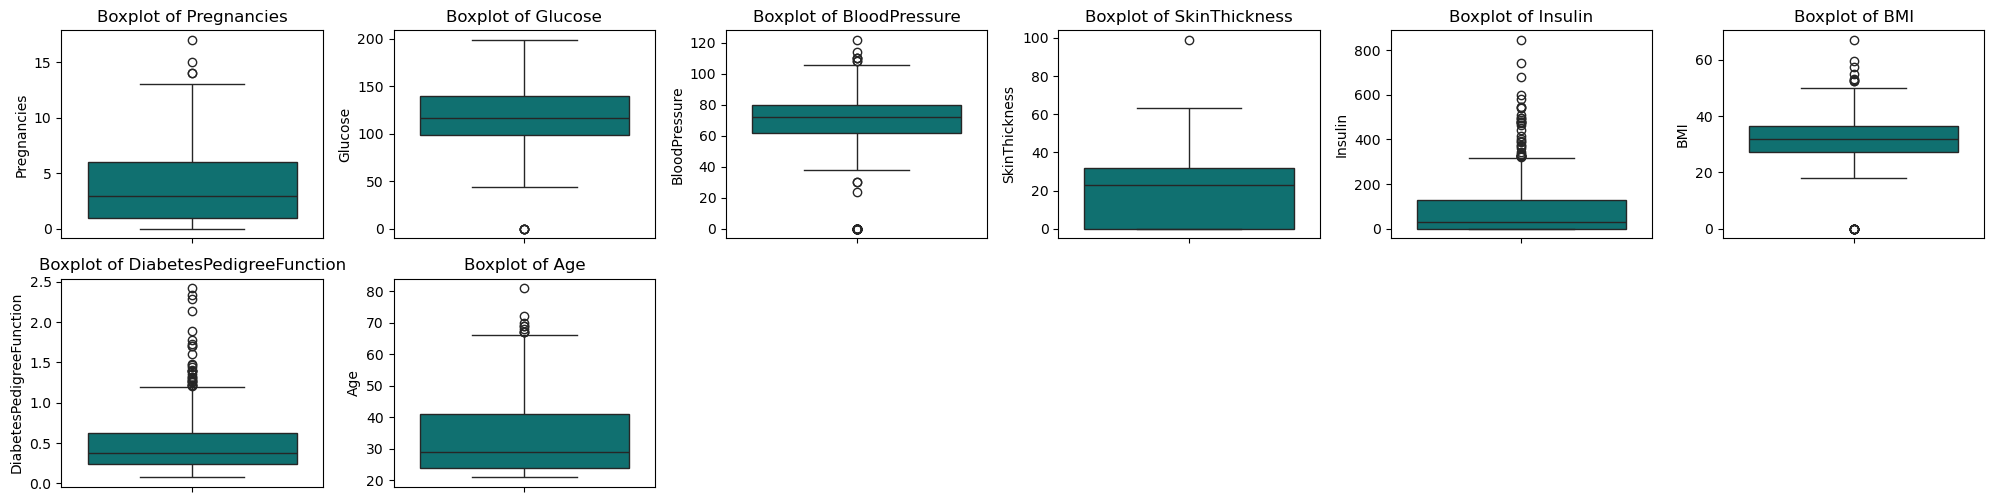

In [54]:
plt.figure(figsize=(20,15))
plot=1
for col in df.columns[:-1]:
    plt.subplot(6,6,plot)
    sns.boxplot(df[col], color='teal')
    plt.title(f"Boxplot of {col}")
    plot+=1
plt.tight_layout()
plt.show()

In [55]:
for col in df.columns[:-1]:
    if skew(df[col]) > 0.5:
        df[col] = np.log1p(df[col])

In [56]:
print("Skewness After:\n")
for col in df.columns[:-1]:
    print(f"{col}: {skew(df[col]):.4f}")

Skewness After:

Pregnancies: -0.2430
Glucose: 0.1734
BloodPressure: -1.8400
SkinThickness: 0.1092
Insulin: 0.0658
BMI: -0.4281
DiabetesPedigreeFunction: 1.1158
Age: 0.6135


In [57]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [59]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"\nCross-Validation Accuracy (5-Fold): {cv_scores.mean():.4f}")
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 150, 200]
}
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters Found:", grid_search.best_params_)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

c:\Users\ruthr\anaconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ruthr\anaconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ruthr\anaconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ruthr\anaconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_labe


Cross-Validation Accuracy (5-Fold): 0.7475
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


c:\Users\ruthr\anaconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [60]:
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")


Train Accuracy: 0.8893
Test Accuracy : 0.7532


In [61]:
print("Classification report",classification_report(y_test, y_pred_test, target_names=['No Diabetes', 'Diabetes']))

Classification report               precision    recall  f1-score   support

 No Diabetes       0.79      0.84      0.82       100
    Diabetes       0.67      0.59      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



In [62]:
accuracy = accuracy_score(y_test,y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.7532
Precision: 0.6667
Recall: 0.5926
F1 Score: 0.6275
ROC-AUC: 0.7163


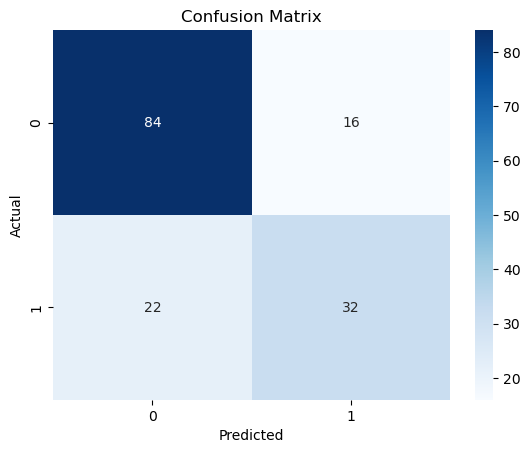

In [63]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [64]:
with open("diabetes_xgboost.pkl", "wb") as f:
    pickle.dump(best_model, f)